<a href="https://colab.research.google.com/github/diegovalensuela/datascience/blob/master/Previsao_de_Doen%C3%A7as_Cardiovasculares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color='orange'> 0.0. Business Understanding </font>
>

In [ ]:
# 1.0. Estratégia da Soluçao
    -- Entender o objetivo do Projeto:
        -- aumentar a precisão do diagnóstico

    -- Porque?
        -- Qual o modelo de negócio da empresa Cardio Catch Diseases (CCD)?  
            -- O modelo de negócio é do tipo Serviço:
               (a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço)
            -- Demanda: pessoas procurando diagnostico precoce e pagando R$500 a cada 5% de precisão após os 50%  
               (se o diagnóstico for 50% ou menos o cliente não paga nada)

        -- Cenário atual
            -- processo feito manualmente, onde a equipe tem uma precisão variando entre 55% a 65% com o 
               custo de diagnostico em torno de R$1000,00

    -- Proposta de Solucao:
        -- Modelo de Machine Learning que bata os 65% de precisão atual, acarretando com a diminuição no 
           gasto de R$1000,00 por cada diagostico
            
# 2.0. Ciclos para criar solução
    -- C1  Entender os dados
    -- C2. Criar hipoteses de negócio
            -- H1. Fumantes tem mais diagnosticos positivos
            -- H2. Glicose alta impacta mais em diagnosticos positivos 
            -- H3. Colesterol alto impacta mais em diagnosticos positivos
            -- H4. Pacientes fumantes tem pressão maior 
            -- H5. Porcentagem de homens com diagnostico positivo é maior
            -- H6. Quanto mais velho, mais casos positivos
            -- H7. A pressao arterial aumenta conforme o nivel do colesterol
            -- H8. Há mais casos negativos que positivos
            -- H9. Há muito mais pacientes que não fazem atividades fisicas do que fazem
            -- H10. Pacientes que fazem atividade fisica tem menos diagnosticos positivos   
    -- C3. Analise exploratória de dados 
            -- Validar ou refutar hiposteses
            -- Tratar Outliers e/ou valores ausentes
    -- C4. Dividir o modelo e treinar
    -- C5. Terminar o modelo
            -- Validar a performance do modelo

### <font color='orange'> 1.0. imports </font>

In [17]:
import pandas as pd
from sklearn import linear_model as lm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# ignorar avisos de alerta
warnings.filterwarnings("ignore")

### <font color='orange'> 2.0. Loading data </font>

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/diegovalensuela/datascience/master/Datasets/cardio_dataset/cardio_train.csv', 
                 sep=';')

In [ ]:
# visualizar as primeiras 5 entradas do dataset
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
age         = Idade do paciente em dias
gender      = Genero do paciente, sendo 1 para mulher e 2 para homem;
height      = Altura em cm;
weight      = Peso em Kg;
ap_hi       = Pressão arterial sistolica
ap_lo       = Pressão arterial diastólica
cholesterol = Nivel do colesterol, sendo 1 para normal, 2 para acima do normal e 3 para muito acima do normal
gluc        = Nivel de glicose, sendo 1 para normal, 2 para acima do normal e 3 para muito acima do normal
smoke       = Paciente ser fumante ou não
alco        = Paciente ser alcoolatra ou não
active      = Paciente ser ativo, se pratica esporte ou não
cardio      = Variavel target

In [ ]:
          # https://www.diferenca.com/sistole-e-diastole/#:~:text=A%20s%C3%ADstole%20%C3%A9%20a%20fase,diast%C3%B3lica%20%C3%A9%20de%2080%20mmHg.

          A sistole e a diastole são dois estágios do ciclo cardíaco. A sístole é a fase de contração do coração, 
          onde o sangue é bombeado para os vasos sanguíneos. 
          já a diástole é a fase de relaxamento, fazendo com que o sangue entre no coração.
          
          Em um adulto normal, a média da pressão sistólica é de 120 milímetros de mercúrio (mmHg), enquanto a diastólica é de 80 mmHg.
          Então, se o médico diz que sua pressão está 12 por 8, significa que na sístole ela é de 120 mmHg e na diástole é de 80 mmHg.

          A leitura da pressão sanguínea é medida em milímetros de mercúrio (mmHg) e é fornecida em dois números.

### <font color='orange'> 3.0. Data Preparation </font>

In [21]:
# criar a variavel idade em anos para melhor visualizacao
df['idade'] = round(df['age'].apply(lambda x: int(x)/365))

In [22]:
# identificar o tipo das variaveis
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
idade          float64
dtype: object

In [23]:
# ver se há valores faltantes
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
idade          0
dtype: int64

In [24]:
# quantos pacientes de cada sexo / 1 - Mulher 2 - Homem
df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

#### <font color='orange'> 3.1. Hypotheses Validation </font>

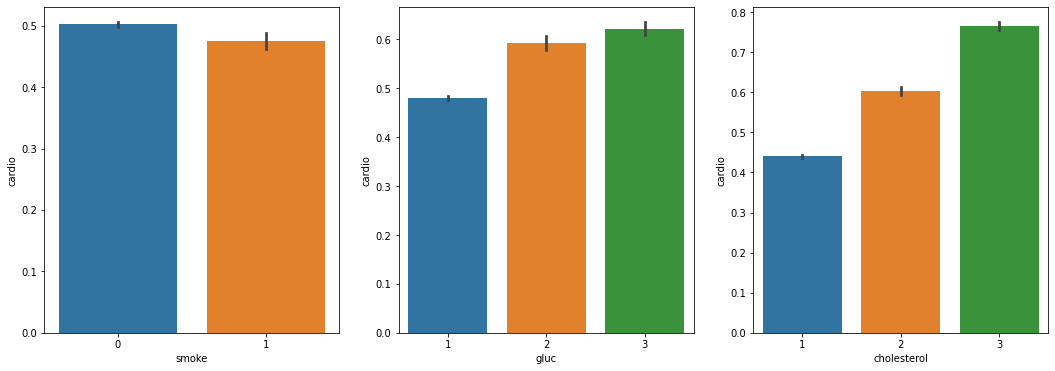

In [25]:
# plotar graficos para cardio vs smoke, gluc e cholesterol
# H1, H2 e H3;
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='smoke', y='cardio', data=df, ax=axis1)
sns.barplot(x='gluc', y='cardio', data=df, ax=axis2)
sns.barplot(x='cholesterol', y='cardio', data=df, ax=axis3);

In [26]:
# verificar a média da pressão sistolica em fumantes
#H4
df[['smoke', 'ap_hi']].groupby(['smoke']).mean()

,ap_hi
smoke,
0,128.861431
1,128.360512


In [27]:
# verificar a média da pressão diastolica em fumantes
# H4
df[['smoke', 'ap_lo']].groupby(['smoke']).mean()

,ap_lo
smoke,
0,96.326550
1,99.774518


In [28]:
# qual genero tem mais diagnosticos positivos? 1 - Mulher 2 - Homem
# H5
df[['gender', 'cardio']].groupby(['gender']).mean()

,cardio
gender,
1,0.496727
2,0.505231


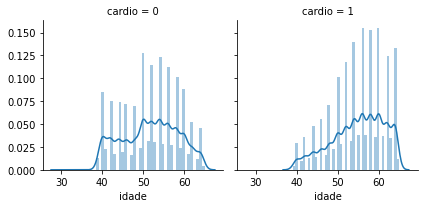

In [29]:
# ver a influencia da idade na probabilidade de diagnóstico positivo
# H6
idade_relacao = sns.FacetGrid(df, col='cardio')
idade_relacao.map(sns.distplot, 'idade');

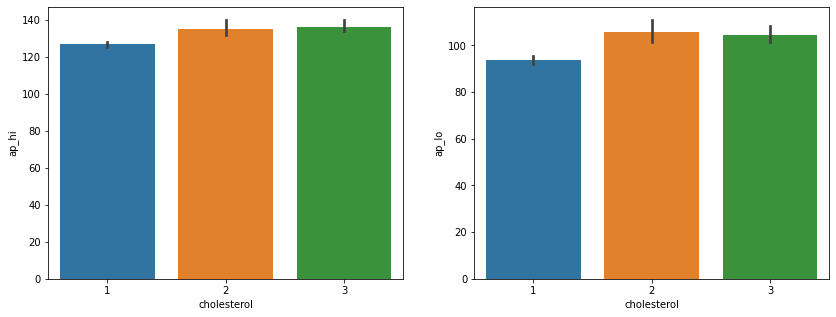

In [30]:
# verificar o nivel de pressão em relação ao colesterol alto
# H7
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x='cholesterol', y='ap_hi', data=df, ax=axis1)
sns.barplot(x='cholesterol', y='ap_lo', data=df, ax=axis2);

Diagnósticos:
0    0.5003
1    0.4997
Name: cardio, dtype: float64


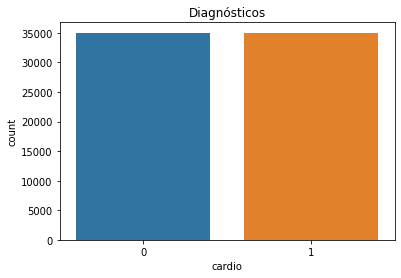

In [31]:
# ver porcentagem dos diagnosticos / sendo 0 - negativo e 1 - positivo
# H8
print('Diagnósticos:')
print(df.cardio.value_counts()/ df.shape[0])

# plotar grafico de barras com os diagnosticos
fig, ax = plt.subplots()
sns.countplot('cardio', data=df, ax=ax)
ax.set_title('Diagnósticos')
plt.show();

In [32]:
# quantos pacientes realizam atividade fisica (sendo 1 - ativo fisicamente; 2 - não ativo fisicamente)
# H9
df['active'].value_counts()

1    56261
0    13739
Name: active, dtype: int64

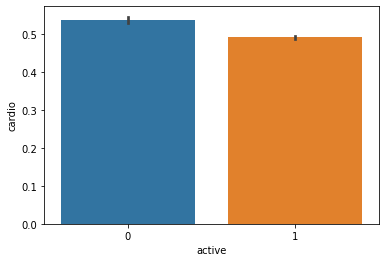

In [33]:
# plotar graficos para cardio vs active 
# H10
sns.barplot(x='active', y='cardio', data=df);

#### <font color='orange'> 3.2. Detecção de Outliers </font>

In [34]:
# distribuicao estatistica dos dados
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


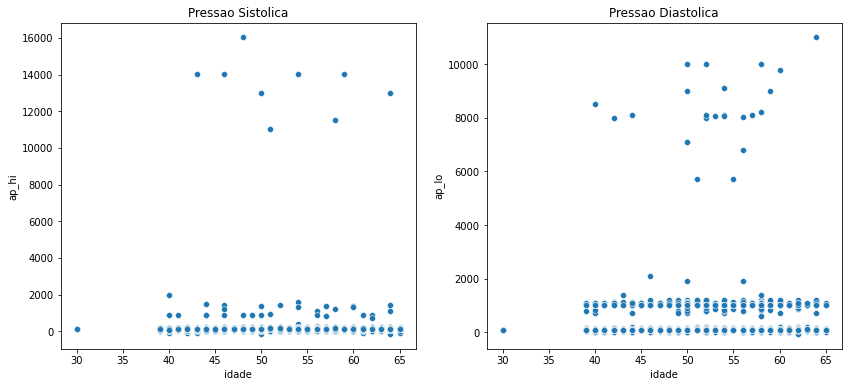

In [35]:
# verificar outliers da variavel ap_hi (sistolica) e ap_lo (distolica)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='idade', y='ap_hi', data=df, ax=axis1)
axis1.set_title('Pressao Sistolica')
sns.scatterplot(x='idade', y='ap_lo', data=df, ax=axis2)
axis2.set_title('Pressao Diastolica');

In [36]:
# tratamento de Outlier para ap_hi(Pressao Sistolica)
# interquartil
IQR_sistolic = df.ap_hi.quantile(0.75) - df.ap_hi.quantile(0.25)
quartil_inf_sistolic = df.ap_hi.quantile(0.25) - (3 * IQR_sistolic)
quartil_sup_sistolic = df.ap_hi.quantile(0.75) + (3 * IQR_sistolic)
print('Os valores de Pressão Sistolica que serão considerados Outliers estao entre {} e {}'. format(quartil_inf_sistolic,quartil_sup_sistolic))

Os valores de Pressão Sistolica que serão considerados Outliers estao entre 60.0 e 200.0


In [37]:
# tratamento de Outlier para ap_lo(Pressao Diastolica)
# interquartil
IQR_distolic = df.ap_lo.quantile(0.75) - df.ap_lo.quantile(0.25)
quartil_inf_distolic = df.ap_lo.quantile(0.25) - (3 * IQR_distolic)
quartil_sup_distolic = df.ap_lo.quantile(0.75) + (3 * IQR_distolic)
print('Os valores de Pressão Diastolica que serão considerados Outliers estao entre {} e {}'. format(quartil_inf_distolic,quartil_sup_distolic))

Os valores de Pressão Diastolica que serão considerados Outliers estao entre 50.0 e 120.0


In [38]:
# identificar quantos valores estão sendo considerados outliers, seja abaixo ou acima
print('Valores maiores que 200 na coluna ap_hi: {}'.format(df.loc[(df['ap_hi'] > 200)].value_counts().sum()))
print('Valores maiores que 120 na coluna ap_lo: {}'.format(df.loc[(df['ap_lo'] > 120)].value_counts().sum()))
print('Valores menores que 60 na coluna ap_hi: {}'.format(df.loc[(df['ap_hi'] < 60)].value_counts().sum()))
print('Valores menores que 50 na coluna ap_lo: {}'.format(df.loc[(df['ap_lo'] < 50)].value_counts().sum()))

Valores maiores que 200 na coluna ap_hi: 100
Valores maiores que 120 na coluna ap_lo: 1056
Valores menores que 60 na coluna ap_hi: 188
Valores menores que 50 na coluna ap_lo: 80


In [39]:
# substituicao dos outliers na variavel ap_hi (Pressao Sistolica)
def sistolic_outlier(df):
  media_sistolic = round(df['ap_hi'].mean())
  df['ap_hi'] = np.where(df['ap_hi'] > 200, media_sistolic, df['ap_hi'])
  df['ap_hi'] = np.where(df['ap_hi'] < 60, media_sistolic, df['ap_hi'])
sistolic_outlier(df)

In [40]:
# substituicao dos outliers na variavel ap_lo (Pressao Distolica)
def distolic_outlier(df):
  media_distolic = round(df['ap_lo'].mean())
  df['ap_lo'] = np.where(df['ap_lo'] > 120, media_distolic, df['ap_lo'])
  df['ap_lo'] = np.where(df['ap_lo'] < 50, media_distolic, df['ap_lo'])
distolic_outlier(df)

In [41]:
# validar os valores de pressão arterial
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,126.932200,16.858337,60.0,120.00,120.0,140.00,200.0
ap_lo,70000.0,81.559543,9.490845,50.0,80.00,80.0,90.00,120.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


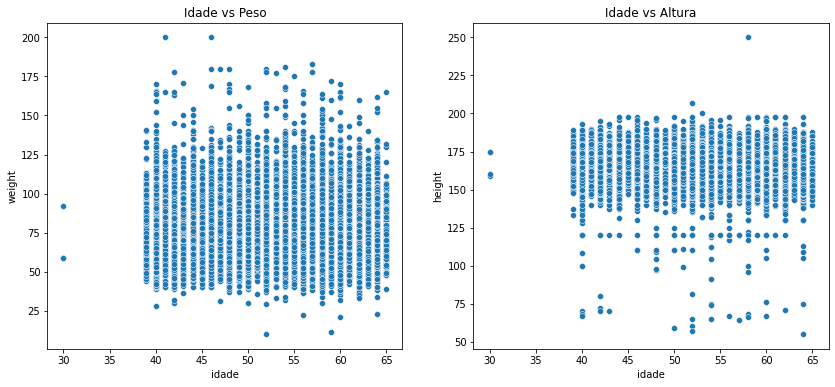

In [42]:
# verificar outliers da variavel weight (Peso) e height (Altura)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='idade', y='weight', data=df, ax=axis1)
axis1.set_title('Idade vs Peso')
sns.scatterplot(x='idade', y='height', data=df, ax=axis2)
axis2.set_title('Idade vs Altura');

In [43]:
# verificando outliers na variavel weight (Peso)
IQR_weight = df.weight.quantile(0.75) - df.weight.quantile(0.25)
quartil_inf_weight = df.weight.quantile(0.25) - (IQR_weight * 3)
quartil_sup_weight = df.weight.quantile(0.75) + (IQR_weight * 3)
print('Os valores de Peso que são considerados Outliers: abaixo de {} e acima de {}'. format(quartil_inf_weight,
                                                                                             quartil_sup_weight))

Os valores de Peso que são considerados Outliers: abaixo de 14.0 e acima de 133.0


In [44]:
# verificando outliers na variavel height (Altura)
IQR_height = df.height.quantile(0.75) - df.height.quantile(0.25)
quartil_inf_height = df.height.quantile(0.25) - (IQR_height * 3)
quartil_sup_height = df.height.quantile(0.75) + (IQR_height * 3)
print('Os valores de Altura que são considerados Outliers: abaixo de {} e acima de {}'. format(quartil_inf_height,
                                                                                               quartil_sup_height))

Os valores de Altura que são considerados Outliers: abaixo de 126.0 e acima de 203.0


In [45]:
# substituicao dos outliers na variavel weight (Peso)
def weight_outlier(df):
  media_weight = df['weight'].mean()
  df['weight'] = np.where(df['weight']<50, media_weight, df['weight'])
weight_outlier(df)

In [46]:
# substituicao dos outliers na variavel height (Altura)
def height_outlier(df):
  media_height = df['height'].mean()
  df['height'] = np.where(df['height']>203, media_height, df['height'])
  df['height'] = np.where(df['height']<126, media_height, df['height'])
height_outlier(df)

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.437806,7.853317,128.0,159.00,165.0,170.00,200.0
weight,70000.0,74.613241,13.966613,50.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,126.932200,16.858337,60.0,120.00,120.0,140.00,200.0
ap_lo,70000.0,81.559543,9.490845,50.0,80.00,80.0,90.00,120.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [48]:
# verificando outliers na variavel age (Idade)
IQR_age = df.age.quantile(0.75) - df.age.quantile(0.25)
quartil_inf_age = df.age.quantile(0.25) - (IQR_age * 3)
quartil_sup_age = df.age.quantile(0.75) + (IQR_age * 3)
print('Os valores de Idade que são considerados Outliers: abaixo de {} e acima de {}'. format(quartil_inf_age,
                                                                                              quartil_sup_age))
print('Variavel (age) tem o valor minimo de {} e maximo de {}'.format(min(df['age']), max(df['age'])))

Os valores de Idade que são considerados Outliers: abaixo de 6675.0 e acima de 32316.0
Variavel (age) tem o valor minimo de 10798 e maximo de 23713


#### <font color='orange'> 3.3. Dummie Variables </font>

In [49]:
# variaveis dummie para cholesterol
cholesterol_dummies = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
df = pd.concat([df, cholesterol_dummies], axis=1)
df.drop('cholesterol', axis=1, inplace=True)

In [50]:
# variaveis dummie para gluc
gluc_dummies = pd.get_dummies(df['gluc'], prefix='gluc')
df = pd.concat([df, gluc_dummies], axis=1)
df.drop('gluc', axis=1, inplace=True)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,idade,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,18393,2,168.0,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,1,20228,1,156.0,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,2,18857,1,165.0,64.0,130,70,0,0,0,1,52.0,0,0,1,1,0,0
3,3,17623,2,169.0,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,4,17474,1,156.0,56.0,100,60,0,0,0,0,48.0,1,0,0,1,0,0


#### <font color='orange'> 3.4. Data preparation - Split </font>

In [51]:
# features 
X = df.drop(['cardio', 'idade', 'id'], axis=1)

# response variable
y = df['cardio']

In [52]:
# padronizar as colunas numericas
X = StandardScaler().fit_transform(X)

In [53]:
# dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### <font color='orange'> 4.0. Model Training </font>

In [54]:
# model description
model_lr = lr(solver='liblinear', random_state=0)

# model training
model_lr.fit(X_train, y_train);

In [55]:
# realizar as previsões no dataset de treino
resultado = model_lr.predict(X_test)

### <font color='orange'> 5.0. Performance Metrics </font>

In [56]:
# ver acurácia do modelo
print('Acuracia: ', round(accuracy_score(y_test, resultado)*100,2))

Acuracia:  73.23


In [ ]:
          # Avaliações dos modelos
              -- 001 Decision Tree
                    -- padronizado + dummies:     0.6384
                    -- padronizado:               0.6393
                    -- dummies:                   0.6335

              -- 002 Random Forest
                    -- padronizado + dummies:     0.7188
                    -- padronizado:               0.7104
                    -- dummies:                   0.7108

              -- 003 Naive Bayes
                    -- padronizado + dummies:     0.6753
                    -- padronizado:               0.7090
                    -- dummies:                   0.6821

              -- 004 Regressao Linear
                    -- padronizado + dummies:     0.7296  
                    -- padronizado:               0.7268      
                    -- dummies:                   0.7170